<a href="https://colab.research.google.com/github/boemer00/deep_learning/blob/main/TF2.0_ecoli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 1: Load the Data

In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

In [23]:
from google.colab import files
uploaded = files.upload()

Saving ecoli.csv to ecoli (1).csv


In [197]:
# Load dataset
df = pd.read_csv('ecoli.csv', delim_whitespace=True)

# Assign names to columns
df.columns = ['seq_name', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2', 'site']

# drop unnecessary column as sequence names are all unique
df = df.drop('seq_name', axis=1)

# Encode Data
df['site'].replace(('cp', 'im', 'pp', 'imU', 'om', 'omL', 'imL', 'imS'), (0, 1, 2, 3, 4, 5, 6, 7), inplace=True)

In [198]:
df.head()

,mcg,gvh,lip,chg,aac,alm1,alm2,site
0,0.07,0.40,0.48,0.5,0.54,0.35,0.44,0
1,0.56,0.40,0.48,0.5,0.49,0.37,0.46,0
2,0.59,0.49,0.48,0.5,0.52,0.45,0.36,0
3,0.23,0.32,0.48,0.5,0.55,0.25,0.35,0
4,0.67,0.39,0.48,0.5,0.36,0.38,0.46,0


In [199]:
# Check for null values
df.isnull().sum()

mcg     0
gvh     0
lip     0
chg     0
aac     0
alm1    0
alm2    0
site    0
dtype: int64

In [200]:
# Step 1: Calculate the frequency counts using value_counts()
frequency_counts = df['site'].value_counts()

# Step 2: Convert frequency_counts to a DataFrame
frequency_table = pd.DataFrame({'site': frequency_counts.index, 'count': frequency_counts.values})

# Step 3: Calculate the percentage and add it as a new column
total_samples = len(df)
frequency_table['percentage'] = (frequency_table['count'] / total_samples) * 100

# Step 4: Calculate the site percentile and add it as a new column
frequency_table['site_percentile'] = (frequency_table['count'].rank(ascending=False) / len(frequency_table)) * 100

# Step 5: Print table
frequency_table

,site,count,percentage,site_percentile
0,0,142,42.388060,12.50
1,1,77,22.985075,25.00
2,2,52,15.522388,37.50
3,3,35,10.447761,50.00
4,4,20,5.970149,62.50
5,5,5,1.492537,75.00
6,7,2,0.597015,93.75
7,6,2,0.597015,93.75


Because the frequency of some sites are tiny, I will drop those rows with site = `5`, `6`, and `7`.

In [201]:
less_sites = [5, 6, 7]

df = df[~df['site'].isin(less_sites)]

df.describe().T

,count,mean,std,min,25%,50%,75%,max
mcg,326.0,0.494202,0.194016,0.00,0.34,0.495,0.6575,0.89
gvh,326.0,0.500583,0.149711,0.16,0.40,0.470,0.5700,1.00
lip,326.0,0.484785,0.049730,0.48,0.48,0.480,0.4800,1.00
chg,326.0,0.500000,0.000000,0.50,0.50,0.500,0.5000,0.50
aac,326.0,0.499264,0.123309,0.00,0.42,0.490,0.5700,0.88
alm1,326.0,0.498252,0.217197,0.03,0.33,0.450,0.7100,1.00
alm2,326.0,0.503589,0.207090,0.00,0.35,0.430,0.7100,0.99
site,326.0,1.122699,1.251574,0.00,0.00,1.000,2.0000,4.00


In [202]:
# Split features and target
X = df.drop(columns=['site'])
y = df['site']

In [203]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [204]:
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

{0: 24, 1: 21, 2: 11, 3: 7, 4: 3}


In [205]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [206]:
# Convert integer labels to one-hot encoded labels
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

In [207]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(260, 7) (260, 5)
(66, 7) (66, 5)


## Part 2: Initialize Model

In [208]:
def initialize_model():
    # architecture
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=7))
    model.add(Dropout(0.5))  # Add dropout to prevent overfitting
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))  # Add dropout to prevent overfitting
    model.add(Dense(5, activation='softmax'))

    # compile
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [209]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 64)                512       
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_25 (Dense)            (None, 5)                 165       
                                                                 
Total params: 2,757
Trainable params: 2,757
Non-trainable params: 0
_________________________________________________________________


In [210]:
model = initialize_model()

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    verbose=0)

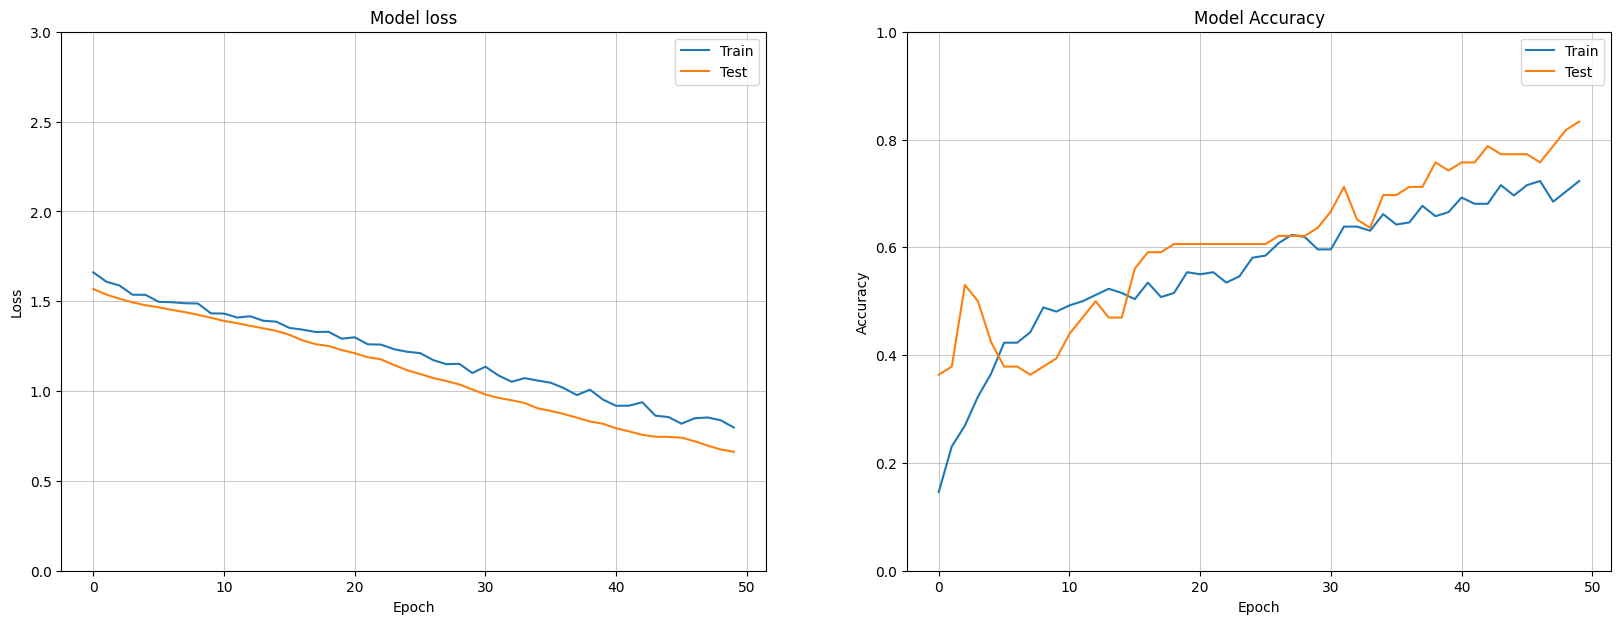

In [211]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])

    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')

    ax[0].set_ylim((0,3))

    ax[0].legend(['Train', 'Test'], loc='best')

    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])

    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')

    ax[1].legend(['Train', 'Test'], loc='best')

    ax[1].set_ylim((0,1))

    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

plot_loss_accuracy(history, title=None)

# Part 3: Making Predictions

In [212]:
y_pred = model.predict(X_test)

3/3 [==============================] - 0s 3ms/step


In [213]:
print('Length of y_test:', len(y_test))
print('Length of y_pred:', len(y_pred))

Length of y_test: 66
Length of y_pred: 66


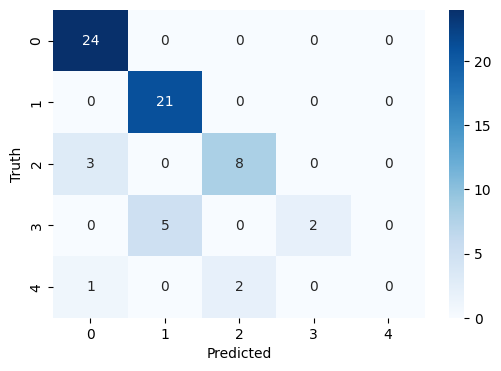

In [214]:
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [216]:
def print_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    # Convert to DataFrame
    cm_df = pd.DataFrame(cm)

    # Optional: Assign column and index names
    # Assuming you have the names of your classes in a list named 'classes'
    # cm_df.columns = classes
    # cm_df.index = classes

    print(cm_df)

# Call the function with y_test and y_pred
print_confusion_matrix(y_test, y_pred)

    0   1  2  3  4
0  24   0  0  0  0
1   0  21  0  0  0
2   3   0  8  0  0
3   0   5  0  2  0
4   1   0  2  0  0


Starting with class 0, the model did exceptionally well. It correctly predicted all 24 instances without any misclassifications. Similarly, for class 1, the model correctly classified all 21 instances.

However, when it comes to class 2, there are some misclassifications. While the model correctly predicted 8 instances of class 2, it incorrectly predicted 3 instances of class 2 as class 0.

Class 3 is where my model faced the most difficulties. Out of the total instances of class 3, it only correctly classified 2. It wrongly classified 5 instances of class 3 as class 1.

For class 4, the model correctly classified none of the instances. It misclassified 1 instance as class 0 and 2 instances as class 2.

In summary, the model's performance is great for classes 0 and 1 but it starts to be less accurate for classes 2, 3, and 4. For these classes, the model seems to be having difficulties distinguishing between them.

There could be a number of reasons for the poor performance on classes 2, 3, and 4. Here is one explanation:

**Imbalanced Dataset**: There are significantly more examples of classes 0 and 1 than classes 2, 3, and 4 in the training data. Therefore, the model might struggle to learn the characteristics of classes 2, 3, and 4. Techniques like oversampling the minority classes, undersampling the majority classes, or using a combination (SMOTE) can help with this.